<a href="https://colab.research.google.com/github/chi-hun/dacon/blob/main/%EC%BD%94%EC%8A%A4%ED%8F%AC_X_%EB%8D%B0%EC%9D%B4%EC%BD%98_%EC%9E%90%EB%8F%99%EC%B0%A8_%EC%B6%A9%EB%8F%8C_%EB%B6%84%EC%84%9D_AI_%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

코스포 X 데이콘 자동차 충돌 분석 AI 경진대회

https://dacon.io/competitions/official/236064/overview/description

In [1]:
 pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 43.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt
import glob
import tqdm.auto
import albumentations as A
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import random
from sklearn.model_selection import StratifiedKFold
import tensorflow_addons as tfa

In [3]:
CFG = {'frame' : 10,
       'img_size' : 224,
       'batch_size' : 4,
       'n_kfold' : 10,
       'n_class' : 13,
       'learning_rate' : 0.0003}

In [4]:
!unzip '/content/drive/MyDrive/Colab Notebooks/데이콘/open.zip'

Archive:  /content/drive/MyDrive/Colab Notebooks/데이콘/open.zip
  inflating: sample_submission.csv   
   creating: test/
  inflating: test/TEST_0551.mp4      
  inflating: test/TEST_0324.mp4      
  inflating: test/TEST_0701.mp4      
  inflating: test/TEST_1249.mp4      
  inflating: test/TEST_0780.mp4      
  inflating: test/TEST_1311.mp4      
  inflating: test/TEST_0300.mp4      
  inflating: test/TEST_1104.mp4      
  inflating: test/TEST_0687.mp4      
  inflating: test/TEST_0315.mp4      
  inflating: test/TEST_0202.mp4      
  inflating: test/TEST_1089.mp4      
  inflating: test/TEST_0412.mp4      
  inflating: test/TEST_1726.mp4      
  inflating: test/TEST_0402.mp4      
  inflating: test/TEST_1388.mp4      
  inflating: test/TEST_0275.mp4      
  inflating: test/TEST_0390.mp4      
  inflating: test/TEST_0992.mp4      
  inflating: test/TEST_0236.mp4      
  inflating: test/TEST_0450.mp4      
  inflating: test/TEST_0802.mp4      
  inflating: test/TEST_0101.mp4      
  i

In [5]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
sub = pd.read_csv('/content/sample_submission.csv')
train['video_path'] = '/content' + train['video_path'].str[1:]
test['video_path'] = '/content' + test['video_path'].str[1:]
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2698 entries, 0 to 2697
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   sample_id   2698 non-null   object
 1   video_path  2698 non-null   object
 2   label       2698 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 63.4+ KB


In [11]:
train.label.value_counts()

0     1783
1      318
7      317
3       78
2       51
9       34
11      33
8       30
5       28
4       13
12       6
10       4
6        3
Name: label, dtype: int64

# EDA

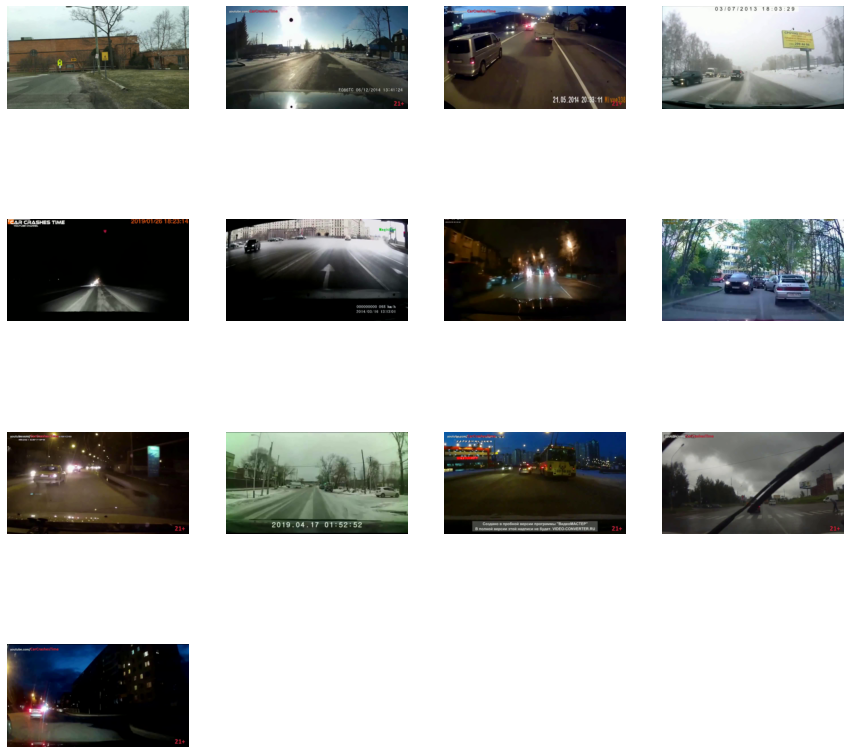

In [17]:
plt.figure(figsize=(15,15))
for i in range(13):
    plt.subplot(4,4,i+1)
    train_se = train[train['label'] == i]
    video = cv2.VideoCapture(train_se['video_path'].values[0])
    image = []
    for x in range(CFG['frame']):
         _, img = video.read()
         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
         image.append(img)
    plt.imshow(image[0])
    plt.axis(False)
plt.show()

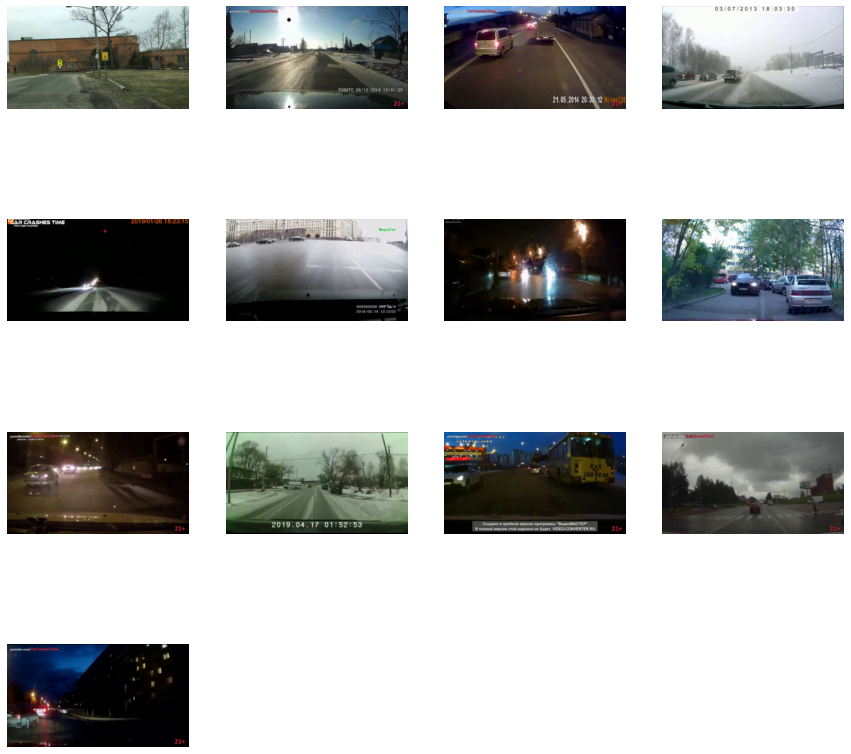

In [19]:
plt.figure(figsize=(15,15))
for i in range(13):
    plt.subplot(4,4,i+1)
    train_se = train[train['label'] == i]
    video = cv2.VideoCapture(train_se['video_path'].values[0])
    image = []
    for x in range(CFG['frame']):
         _, img = video.read()
         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
         image.append(img)
    plt.imshow(image[9])
    plt.axis(False)
plt.show()

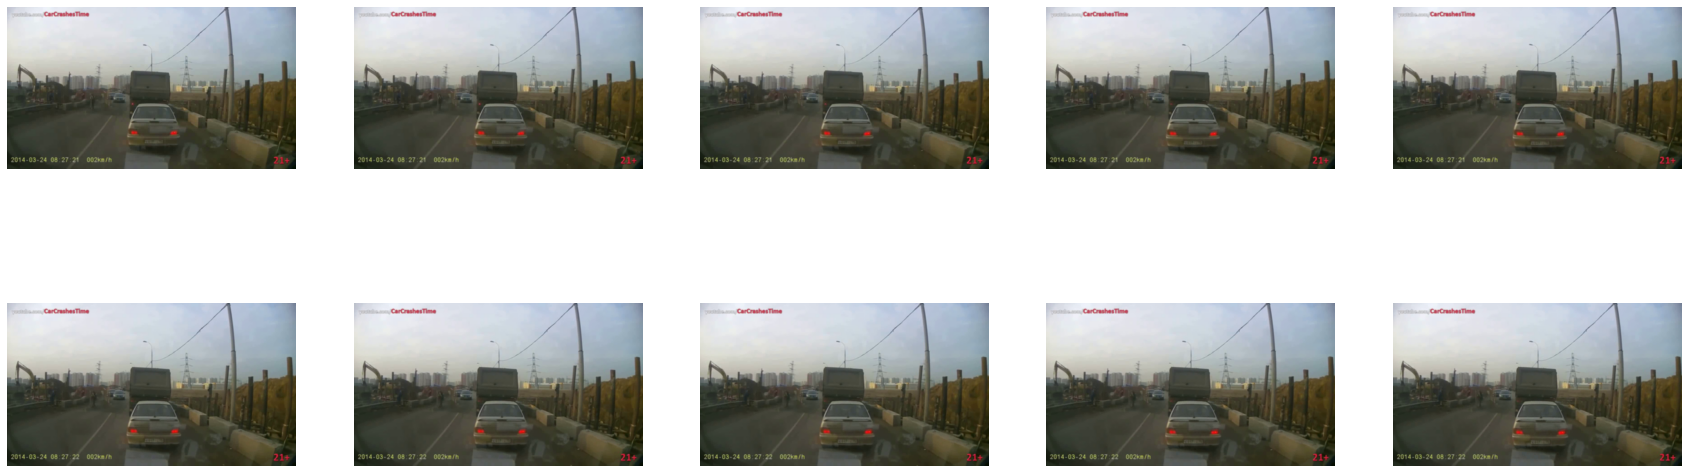

In [36]:
plt.figure(figsize=(30,10))
train_se = train[train['label'] == 7]
video = cv2.VideoCapture(train_se['video_path'].values[84])
image = []
for i in range(CFG['frame']):
    plt.subplot(2,5,i+1)
    _, img = video.read()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis(False)
plt.show()

# CNN

In [6]:
argument = A.Compose([A.ShiftScaleRotate(p=0.5),
                      A.RandomBrightnessContrast(p=0.5),
                      A.RandomFog(p=0.5),
                      #A.Rotate(10, p=0.5)
                      ],p=0.5)
class data_maker(tf.keras.utils.Sequence):
    def __init__(self, file_path, label=None, img_size=CFG['img_size'], shuffle=False, argument=None, batch_size=CFG['batch_size']):
        self.file_path = file_path
        self.label = label
        self.img_size = img_size
        self.shuffle = shuffle
        self.argument = argument
        self.batch_size = batch_size

        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.file_path)/self.batch_size))

    def __getitem__(self, index):

        select_idx = self.idx[index * self.batch_size : (index+1) * self.batch_size]
        file_path_select = self.file_path[select_idx]

        images = np.zeros((len(file_path_select), CFG['frame'], self.img_size, self.img_size, 3))
        for i, path in enumerate(file_path_select):
            image = []
            video = cv2.VideoCapture(path)

            for _ in range(CFG['frame']):
                _, img = video.read()
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (self.img_size, self.img_size))
                image.append(img)
            
            if self.argument:
                seed = np.random.randint(0,99999)
                for j, img_ag in enumerate(image):
                    random.seed(seed)
                    img_ag = argument(image=img_ag)['image']
                    image[j] = img_ag
            image = np.array(image)/255
            images[i] = image
        if self.label is not None:
            label_select = self.label[select_idx]
            return images, label_select
        else:
            return images

    def on_epoch_end(self):
        self.idx = np.arange(len(self.file_path))
        if self.shuffle:
            np.random.shuffle(self.idx)

In [11]:
train_x, val_x, train_y, val_y = train_test_split(train['video_path'], pd.get_dummies(train['label']), test_size=0.1, stratify=train['label'])
len(train_x), len(val_x), len(train_y), len(val_y)

(2428, 270, 2428, 270)

In [12]:
train_ds = data_maker(train_x.values, train_y.values, shuffle=True, argument=True)
val_ds = data_maker(train_x.values, train_y.values, shuffle=False, argument=False)
test_ds = data_maker(test['video_path'].values, shuffle=False, argument=False)

In [13]:
def make_model():
    inputs = layers.Input(shape=(CFG['frame'], CFG['img_size'], CFG['img_size'], 3))
    x = layers.Conv3D(3,3,activation='relu',padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool3D((2))(x)
    x = layers.Conv3D(8,3,activation='relu',padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool3D((2))(x)
    x = layers.Conv3D(32,3,activation='relu',padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool3D((2))(x)
    x = layers.Conv3D(64,3,activation='relu',padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool3D((1,7,7))(x)
    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(512,activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    # x = layers.Dense(512,activation='relu')(x)
    # x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(CFG['n_class'], activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    return model

In [14]:
model = make_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 224, 224, 3)  0         
                             ]                                   
                                                                 
 conv3d (Conv3D)             (None, 10, 224, 224, 3)   246       
                                                                 
 batch_normalization (BatchN  (None, 10, 224, 224, 3)  12        
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 5, 112, 112, 3)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 5, 112, 112, 8)    656       
                                                             

In [18]:
model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=[tfa.metrics.F1Score(CFG['n_class'],'macro')])

In [19]:
er = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
lrre = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)
with tf.device('/GPU:0'):
    his = model.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=[er, lrre])

Epoch 1/50
607/607 [==============================] - 294s 469ms/step - loss: 1.1391 - f1_score: 0.0943 - val_loss: 1.0090 - val_f1_score: 0.0927 - lr: 0.0010
Epoch 2/50
607/607 [==============================] - 265s 438ms/step - loss: 1.0505 - f1_score: 0.0972 - val_loss: 0.9462 - val_f1_score: 0.1102 - lr: 0.0010
Epoch 3/50
607/607 [==============================] - 258s 425ms/step - loss: 1.0080 - f1_score: 0.1092 - val_loss: 0.8997 - val_f1_score: 0.1196 - lr: 0.0010
Epoch 4/50
607/607 [==============================] - 275s 453ms/step - loss: 0.9802 - f1_score: 0.1154 - val_loss: 0.8979 - val_f1_score: 0.1303 - lr: 0.0010
Epoch 5/50
607/607 [==============================] - 267s 440ms/step - loss: 0.9574 - f1_score: 0.1132 - val_loss: 0.9621 - val_f1_score: 0.1129 - lr: 0.0010
Epoch 6/50
607/607 [==============================] - 266s 438ms/step - loss: 0.9278 - f1_score: 0.1305 - val_loss: 0.9936 - val_f1_score: 0.1163 - lr: 0.0010
Epoch 7/50
607/607 [==========================

In [20]:
pre = model.predict(test_ds)
pre = pre.argmax(axis=1)
pre

450/450 [==============================] - 97s 215ms/step


array([0, 0, 0, ..., 7, 7, 0])

In [23]:
sub['label'] = pre
sub.to_csv('sub.csv', index=False)

In [7]:
train_t = train.copy()
test_t = test.copy()
def labeling(x):
    if x.label == 0:
        x['crash_0'], x['crash_1'] = 1, 0
        x['ego_0'], x['ego_1'], x['ego_2'] = 0, 0, 1
        x['wheter_0'], x['wheter_1'], x['wheter_2'], x['wheter_3'] = 0, 0, 0 ,1
        x['timing_0'], x['timing_1'], x['timing_2'] = 0, 0, 1
    elif x.label == 1:
        x['crash_0'], x['crash_1'] = 0, 1
        x['ego_0'], x['ego_1'], x['ego_2'] = 0, 1, 0
        x['wheter_0'], x['wheter_1'], x['wheter_2'], x['wheter_3'] = 1, 0, 0 ,0
        x['timing_0'], x['timing_1'], x['timing_2'] = 1, 0, 0
    elif x.label == 2:
        x['crash_0'], x['crash_1'] = 0, 1
        x['ego_0'], x['ego_1'], x['ego_2'] = 0, 1, 0
        x['wheter_0'], x['wheter_1'], x['wheter_2'], x['wheter_3'] = 1, 0, 0 ,0
        x['timing_0'], x['timing_1'], x['timing_2'] = 0, 1, 0
    elif x.label == 3:
        x['crash_0'], x['crash_1'] = 0, 1
        x['ego_0'], x['ego_1'], x['ego_2'] = 0, 1, 0
        x['wheter_0'], x['wheter_1'], x['wheter_2'], x['wheter_3'] = 0, 1, 0 ,0
        x['timing_0'], x['timing_1'], x['timing_2'] = 1, 0, 0
    elif x.label == 4:
        x['crash_0'], x['crash_1'] = 0, 1
        x['ego_0'], x['ego_1'], x['ego_2'] = 0, 1, 0
        x['wheter_0'], x['wheter_1'], x['wheter_2'], x['wheter_3'] = 0, 1, 0 ,0
        x['timing_0'], x['timing_1'], x['timing_2'] = 0, 1, 0
    elif x.label == 5:
        x['crash_0'], x['crash_1'] = 0, 1
        x['ego_0'], x['ego_1'], x['ego_2'] = 0, 1, 0
        x['wheter_0'], x['wheter_1'], x['wheter_2'], x['wheter_3'] = 0, 0, 1 ,0
        x['timing_0'], x['timing_1'], x['timing_2'] = 1, 0, 0
    elif x.label == 6:
        x['crash_0'], x['crash_1'] = 0, 1
        x['ego_0'], x['ego_1'], x['ego_2'] = 0, 1, 0
        x['wheter_0'], x['wheter_1'], x['wheter_2'], x['wheter_3'] = 0, 0, 1 ,0
        x['timing_0'], x['timing_1'], x['timing_2'] = 0, 1, 0
    elif x.label == 7:
        x['crash_0'], x['crash_1'] = 0, 1
        x['ego_0'], x['ego_1'], x['ego_2'] = 1, 0, 0
        x['wheter_0'], x['wheter_1'], x['wheter_2'], x['wheter_3'] = 1, 0, 0 ,0
        x['timing_0'], x['timing_1'], x['timing_2'] = 1, 0, 0
    elif x.label == 8:
        x['crash_0'], x['crash_1'] = 0, 1
        x['ego_0'], x['ego_1'], x['ego_2'] = 1, 0, 0
        x['wheter_0'], x['wheter_1'], x['wheter_2'], x['wheter_3'] = 1, 0, 0 ,0
        x['timing_0'], x['timing_1'], x['timing_2'] = 0, 1, 0
    elif x.label == 9:
        x['crash_0'], x['crash_1'] = 0, 1
        x['ego_0'], x['ego_1'], x['ego_2'] = 1, 0, 0
        x['wheter_0'], x['wheter_1'], x['wheter_2'], x['wheter_3'] = 0, 1, 0 ,0
        x['timing_0'], x['timing_1'], x['timing_2'] = 1, 0, 0
    elif x.label == 10:
        x['crash_0'], x['crash_1'] = 0, 1
        x['ego_0'], x['ego_1'], x['ego_2'] = 1, 0, 0
        x['wheter_0'], x['wheter_1'], x['wheter_2'], x['wheter_3'] = 0, 1, 0 ,0
        x['timing_0'], x['timing_1'], x['timing_2'] = 0, 1, 0
    elif x.label == 11:
        x['crash_0'], x['crash_1'] = 0, 1
        x['ego_0'], x['ego_1'], x['ego_2'] = 1, 0, 0
        x['wheter_0'], x['wheter_1'], x['wheter_2'], x['wheter_3'] = 0, 0, 1 ,0
        x['timing_0'], x['timing_1'], x['timing_2'] = 1, 0, 0
    elif x.label == 12:
        x['crash_0'], x['crash_1'] = 0, 1
        x['ego_0'], x['ego_1'], x['ego_2'] = 1, 0, 0
        x['wheter_0'], x['wheter_1'], x['wheter_2'], x['wheter_3'] = 0, 0, 1 ,0
        x['timing_0'], x['timing_1'], x['timing_2'] = 0, 1, 0
    return x
train_t = train_t.apply(labeling, axis=1)

In [55]:
def retrun_label(pre):
    re = []
    for i in pre:
        if (i == np.array([1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1])).all():
            re.append(0)
        elif (i == np.array([0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0])).all():
            re.append(1)
        elif (i == np.array([0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0])).all():
            re.append(2)
        elif (i == np.array([0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0])).all():
            re.append(3)
        elif (i == np.array([0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0])).all():
            re.append(4)
        elif (i == np.array([0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0])).all():
            re.append(5)
        elif (i == np.array([0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0])).all():
            re.append(6)
        elif (i == np.array([0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0])).all():
            re.append(7)
        elif (i == np.array([0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0])).all():
            re.append(8)
        elif (i == np.array([0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0])).all():
            re.append(9)
        elif (i == np.array([0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0])).all():
            re.append(10)
        elif (i == np.array([0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0])).all():
            re.append(11)
        elif (i == np.array([0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0])).all():
            re.append(12)
        else:
            print(i)
    return re

In [8]:
train_x, val_x, train_y, val_y = train_test_split(train_t['video_path'], train_t.iloc[:,3:].values, test_size=0.1, stratify=train_t['label'])
len(train_x), len(val_x), len(train_y), len(val_y)

(2428, 270, 2428, 270)

In [9]:
train_ds = data_maker(train_x.values, train_y, shuffle=True, argument=True)
val_ds = data_maker(train_x.values, train_y, shuffle=False, argument=False)
test_ds = data_maker(test['video_path'].values, shuffle=False, argument=False)

In [10]:
def make_model():
    inputs = layers.Input(shape=(CFG['frame'], CFG['img_size'], CFG['img_size'], 3))
    x = layers.Conv3D(3,3,activation='relu',padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool3D((2))(x)
    x = layers.Conv3D(8,3,activation='relu',padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool3D((2))(x)
    x = layers.Conv3D(32,3,activation='relu',padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool3D((2))(x)
    x = layers.Conv3D(64,3,activation='relu',padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool3D((1,7,7))(x)
    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(512,activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    # x = layers.Dense(512,activation='relu')(x)
    # x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(12, activation='sigmoid')(x)
    model = tf.keras.Model(inputs, outputs)
    return model

In [11]:
model = make_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 224, 224, 3)  0         
                             ]                                   
                                                                 
 conv3d (Conv3D)             (None, 10, 224, 224, 3)   246       
                                                                 
 batch_normalization (BatchN  (None, 10, 224, 224, 3)  12        
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 5, 112, 112, 3)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 5, 112, 112, 8)    656       
                                                             

In [12]:
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=[tfa.metrics.F1Score(12,'macro')])

In [ ]:
er = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
lrre = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)
with tf.device('/GPU:0'):
    his = model.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=[er, lrre])

Epoch 1/50
607/607 [==============================] - 307s 491ms/step - loss: 0.4207 - f1_score: 0.1666 - val_loss: 0.6338 - val_f1_score: 0.1246 - lr: 0.0010
Epoch 2/50
607/607 [==============================] - 284s 468ms/step - loss: 0.3847 - f1_score: 0.1834 - val_loss: 0.3686 - val_f1_score: 0.1652 - lr: 0.0010
Epoch 3/50
607/607 [==============================] - 278s 459ms/step - loss: 0.3689 - f1_score: 0.1810 - val_loss: 0.4424 - val_f1_score: 0.1048 - lr: 0.0010
Epoch 4/50
607/607 [==============================] - 278s 459ms/step - loss: 0.3548 - f1_score: 0.1856 - val_loss: 0.3175 - val_f1_score: 0.1699 - lr: 0.0010
Epoch 5/50
607/607 [==============================] - ETA: 0s - loss: 0.3452 - f1_score: 0.1879

# resnet

In [24]:
argument = A.Compose([A.ShiftScaleRotate(p=0.5),
                      A.RandomBrightnessContrast(p=0.5),
                      A.HorizontalFlip(p=0.5),
                      #A.Rotate(10, p=0.5)
                      ],p=0.5)
class data_maker(tf.keras.utils.Sequence):
    def __init__(self, file_path, label=None, img_size=CFG['img_size'], shuffle=False, argument=None, batch_size=CFG['batch_size']):
        self.file_path = file_path
        self.label = label
        self.img_size = img_size
        self.shuffle = shuffle
        self.argument = argument
        self.batch_size = batch_size

        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.file_path)/self.batch_size))

    def __getitem__(self, index):

        select_idx = self.idx[index * self.batch_size : (index+1) * self.batch_size]
        file_path_select = self.file_path[select_idx]

        images = np.zeros((len(file_path_select), CFG['frame'], self.img_size, self.img_size, 3))
        for i, path in enumerate(file_path_select):
            image = []
            video = cv2.VideoCapture(path)

            for _ in range(CFG['frame']):
                _, img = video.read()
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (self.img_size, self.img_size))
                image.append(img)
            
            if self.argument:
                seed = np.random.randint(0,99999)
                for j, img_ag in enumerate(image):
                    random.seed(seed)
                    img_ag = argument(image=img_ag)['image']
                    image[j] = img_ag
            image = np.array(image)/255
            images[i] = image
        if self.label is not None:
            label_select = self.label[select_idx]
            return images, label_select
        else:
            return images

    def on_epoch_end(self):
        self.idx = np.arange(len(self.file_path))
        if self.shuffle:
            np.random.shuffle(self.idx)

In [25]:
def make_model2():
    inputs = layers.Input(shape=(CFG['frame'], CFG['img_size'], CFG['img_size'], 3))
    x = layers.Conv3D(16,3,activation='relu',padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x1 = x
    x = layers.Conv3D(16,3,activation='relu',padding='same')(x)
    x = layers.Conv3D(16,3,padding='same')(x)
    x = layers.Add()([x, x1])
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool3D((2))(x)
    x = layers.Conv3D(32,3,activation='relu',padding='same')(x)
    x2 = x
    x = layers.Conv3D(32,3,activation='relu',padding='same')(x)
    x = layers.Conv3D(32,3,padding='same')(x)
    x = layers.Add()([x, x2])
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool3D((2))(x)
    x = layers.Conv3D(64,3,activation='relu',padding='same')(x)
    x3 = x
    x = layers.Conv3D(64,3,activation='relu',padding='same')(x)
    x = layers.Conv3D(64,3,padding='same')(x)
    x = layers.Add()([x, x3])
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool3D((2))(x)
    x = layers.Conv3D(128,3,activation='relu',padding='same')(x)
    x4 = x
    x = layers.Conv3D(128,3,activation='relu',padding='same')(x)
    x = layers.Conv3D(128,3,padding='same')(x)
    x = layers.Add()([x, x4])
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool3D((1,2,2))(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(1024,activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    # x = layers.Dense(512,activation='relu')(x)
    # x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(CFG['n_class'], activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    return model

In [28]:
pre_all = np.zeros((len(test), 5))
skfold = StratifiedKFold(n_splits=CFG['n_kfold'], shuffle=True)
for i, (train_i, val_i) in enumerate(skfold.split(train['video_path'], train['label'])):
    n_fold = CFG['n_kfold']
    print('='*20,f'{i+1}fold/{n_fold}fold','='*20)

    train_d = pd.get_dummies(train, columns=['label'])

    train_dt = train_d.iloc[train_i]
    val_dt = train_d.iloc[val_i]
    train_ds = data_maker(train_dt['video_path'].values, train_dt.loc[:, 'label_0':].values, shuffle=True, argument=True)
    val_ds = data_maker(val_dt['video_path'].values, val_dt.loc[:, 'label_0':].values, shuffle=True, argument=False)
    test_ds = data_maker(test['video_path'].values, shuffle=False, argument=False)
    n_fail = 0
    while True: 
        model = make_model2()
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=CFG['learning_rate']), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=[tfa.metrics.F1Score(CFG['n_class'],'macro')])
        er = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)
        lrre = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)
        model_ceck = tf.keras.callbacks.ModelCheckpoint(f'model_no{i}.h5', monitor='val_loss', save_best_only=True)
        if i == 0:
            with tf.device('/GPU:0'):
                his = model.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=[er, lrre, model_ceck], verbose=1)
        else:
            with tf.device('/GPU:0'):
                his = model.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=[er, lrre, model_ceck], verbose=0)
        best_loss = round(min(his.history['val_loss']),4)
        best_accuracy = round(max(his.history['val_accuracy']),4)
        print(f'best_val_losses : {best_loss}')
        print(f'best_val_accuracy : {best_accuracy}')
        # if best_accuracy > 0.90:
        #     print(f'best_val_losses : {best_loss}')
        #     print(f'best_val_accuracy : {best_accuracy}')
        #     break
        # n_fail += 1
        # print('!'*10,f'{n_fail}fail')
        # print(f'fail_best_val_losses : {best_loss}')
        # print(f'fail_best_val_accuracy : {best_accuracy}')
    pre = model.predict(test_ds, verbose=0) / CFG['n_kfold']
    pre_all += pre

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


==================== 1fold/10fold ====================
Epoch 1/50
607/607 [==============================] - 199s 325ms/step - loss: 1.1373 - f1_score: 0.0881 - val_loss: 1.0894 - val_f1_score: 0.0977 - lr: 3.0000e-04
Epoch 2/50
607/607 [==============================] - 195s 321ms/step - loss: 1.0436 - f1_score: 0.0977 - val_loss: 1.0872 - val_f1_score: 0.0944 - lr: 3.0000e-04
Epoch 3/50
607/607 [==============================] - 195s 321ms/step - loss: 0.9937 - f1_score: 0.1092 - val_loss: 1.0757 - val_f1_score: 0.0986 - lr: 3.0000e-04
Epoch 4/50
173/607 [=======>......................] - ETA: 2:10 - loss: 1.0218 - f1_score: 0.1105

KeyboardInterrupt: ignored

# densenet

In [ ]:
def model_make():
    inputs = layers.Input(shape=(CFG['frame'], CFG['img_size'], CFG['img_size'], 3))
    x = layers.ZeroPadding2D((3,3))(inputs)
    x = layers.Conv2D(64, 7, 2, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.ZeroPadding2D((1,1))(x)
    x = layers.MaxPool2D(3, strides=2)(x)

    x1 = x
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(128, 1, 1, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(32, 3, 1, padding='same')(x)
    x = layers.Concatenate()([x1, x])
    x2 = x
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(128, 1, 1, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(32, 3, 1, padding='same')(x)
    x = layers.Concatenate()([x2, x])
    x3 = x
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(128, 1, 1, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(32, 3, 1, padding='same')(x)
    x = layers.Concatenate()([x3, x])
    x4 = x
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(128, 1, 1, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(32, 3, 1, padding='same')(x)
    x = layers.Concatenate()([x4, x])
    x5 = x
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(128, 1, 1, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(32, 3, 1, padding='same')(x)
    x = layers.Concatenate()([x5, x])
    x6 = x
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(128, 1, 1, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(32, 3, 1, padding='same')(x)
    x = layers.Concatenate()([x6, x])

    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(128, 1, 1, padding='valid')(x)
    x = layers.AveragePooling2D()(x)

    x1 = x
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(128, 1, 1, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(32, 3, 1, padding='same')(x)
    x = layers.Concatenate()([x1, x])
    x2 = x
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(128, 1, 1, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(32, 3, 1, padding='same')(x)
    x = layers.Concatenate()([x2, x])
    x3 = x
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(128, 1, 1, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(32, 3, 1, padding='same')(x)
    x = layers.Concatenate()([x3, x])
    x4 = x
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(128, 1, 1, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(32, 3, 1, padding='same')(x)
    x = layers.Concatenate()([x4, x])
    x5 = x
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(128, 1, 1, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(32, 3, 1, padding='same')(x)
    x = layers.Concatenate()([x5, x])
    x6 = x
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(128, 1, 1, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(32, 3, 1, padding='same')(x)
    x = layers.Concatenate()([x6, x])
    x7 = x
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(128, 1, 1, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(32, 3, 1, padding='same')(x)
    x = layers.Concatenate()([x7, x])
    x8 = x
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(128, 1, 1, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(32, 3, 1, padding='same')(x)
    x = layers.Concatenate()([x8, x])
    x9 = x
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(128, 1, 1, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(32, 3, 1, padding='same')(x)
    x = layers.Concatenate()([x9, x])
    x10 = x
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(128, 1, 1, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(32, 3, 1, padding='same')(x)
    x = layers.Concatenate()([x10, x])
    x11 = x
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(128, 1, 1, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(32, 3, 1, padding='same')(x)
    x = layers.Concatenate()([x11, x])
    x12 = x
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(128, 1, 1, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(32, 3, 1, padding='same')(x)
    x = layers.Concatenate()([x12, x])

    model = tf.keras.Model(inputs, x)
    return model